# 【学习笔记】Hands On Machine Learning - Chap3. Classification

本章首先介绍了 MNIST 数据集，此数据集为 7 万张带标签的手写数字（0-9）图片，它被认为是机器学习领域的 HelloWorld，很多机器学习算法都可以在此数据集上进行训练、调试、对比。

本章核心内容在如何评估一个分类器，介绍了混淆矩阵、Precision 和 Reccall 等衡量正样本的重要指标，及如何对这两个指标进行取舍，此外，还介绍了 ROC 曲线及 AUC 值，当然，肯定少不了 F1Score 了。

最后，本章还介绍了构建多分类器的一般方法。作为科普，你还可以构建多 label 的分类器，以及每个 label 可取不同 value 的分类器。

下面是详细笔记：


## MNIST

MNIST 数据集：70000 张手写数字小图片。这些图片被誉为 ML 中的 Hello World。

手动加载 MNIST 步骤：
1. 下载 [mnist-original.mat](https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat)
2. 调用 `sklearn.datasets.base.get_data_home()` 查看 sklearn 下载到本地的路径
3. 将下载后的文件 `mnist-original.mat` 拷贝到 `get_data_home()/mldata` 目录下
4. 调动 `fetch_mmldata()` 接口，获取 `mnist` 对象：如本地有，就不会从网上下载

In [3]:
from sklearn.datasets.base import get_data_home 
from sklearn.datasets import fetch_mldata
print (get_data_home())
mnist = fetch_mldata('MNIST original')
mnist

/Users/fengyajie/scikit_learn_data


/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
# 查看数据，该数据中包含 70000 张图片，每张图片拥有 784 个 features，
# 因为该图片的规格为 28x28，每个像素的值的范围是 0(white)-255(black)
X,y = mnist["data"],mnist["target"]
print(X.shape,y.shape)

(70000, 784) (70000,)


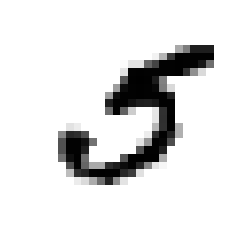

5.0

In [5]:
# 显示其中一个样本
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

In [6]:
# 测试集和训练集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# 打散训练集，避免相似的图片都在一块
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练二分类器

In [7]:
from sklearn.model_selection import cross_val_score
# 识别数字 5 的分类器，使用 sklearn 提供的随机梯度下降算法
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

array([0.9578 , 0.9607 , 0.96775])

## 效果评估
上面模型的准确率很高，有一个原因是其正样本的比例只有 10%，这种情况下，即便我全部猜【不是5】，准确率也有 90% 之高，所以一般我们不用准确率来衡量模型的好坏。

### 混淆矩阵


In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

array([[53556,  1023],
       [ 1252,  4169]])

In [9]:
# 输出Precision score和recall score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
print("precision_score={}, recall_score={}".format(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)))
print("f1_score={}".format(f1_score(y_train_5, y_train_pred)))

precision_score=0.8029661016949152, recall_score=0.7690463014204021
f1_score=0.7856402525204936


### Precision/Recall tradeoff

precision 和 recall 往往不能两全，一个提升了，另一个会下降，这两个指标需要进行权衡，例如在判断视频节目是否对小孩无害的场景下，我们希望 precision 越高越好，同时可以牺牲 recall；而在根据照片预测小偷的场景下，更希望 recall 越高越好。


/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

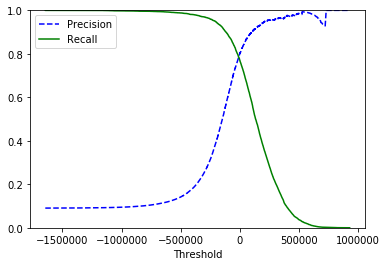

In [10]:
# 绘制 precision 和 recall 曲线
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                 method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC 曲线


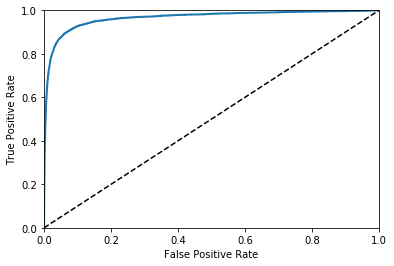

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [12]:
# 计算 AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9655990736206981

使用 F1Score 还是 AUC？取决于正样本和负样本的比例，如果正样本较少，你应该选择 F1Score，否则选择 AUC。

使用随机森林

/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lowe

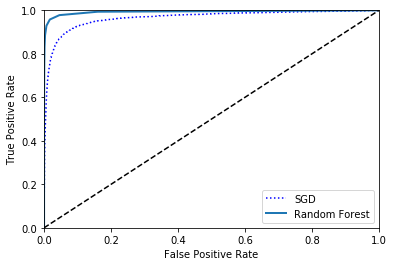

In [13]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [14]:
# 随机森林的 auc
roc_auc_score(y_train_5, y_scores_forest)

0.993283808868663

## 多分类器

分类器的分类
1. 二分类器：Logistic Regression、SVM
2. 多分类器：Random Forest、Naive Bayes

除此之外，你也可以使用二分类器来构造多分类器，例如识别 0-9 十个数字，你可以训练 10 个二分类器，每个分类器用来识别一个数字，当你要预测一个数字时，将该数字分别输入到这十个分类器中，最后获得最高分的那个分类器，就是预测结果。这种方法也被称为 one-versus-all (OvA)


In [15]:
# 在 sklearn 中，其内部会自动训练多个分类器，并且在预测时给出分数最高的那个分类
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([5.])

In [16]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-227250.7532523 , -511911.42747987, -343850.9936749 ,
        -194518.44134798, -341796.12282028,   10728.59041333,
        -798149.80620821, -263564.01751255, -729498.66535121,
        -553349.11568488]])

In [17]:
# 最高分数的下标
np.argmax(some_digit_scores)
# 分类
sgd_clf.classes_
sgd_clf.classes_[5]

5.0

## 错误分析

In [18]:
# 交叉验证 + 混淆矩阵
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/fengyajie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

array([[5757,    4,   17,   11,    9,   38,   35,   11,   38,    3],
       [   2, 6465,   47,   23,    6,   45,    7,   13,  121,   13],
       [  59,   42, 5330,   96,   91,   24,   81,   55,  163,   17],
       [  45,   44,  139, 5352,    0,  227,   35,   56,  130,  103],
       [  22,   26,   37,    8, 5360,    7,   46,   34,   74,  228],
       [  88,   42,   31,  196,   81, 4577,  107,   28,  175,   96],
       [  40,   25,   48,    2,   44,   86, 5616,    9,   48,    0],
       [  24,   19,   69,   32,   58,   10,    4, 5785,   17,  247],
       [  57,  148,   79,  149,   11,  162,   56,   24, 5003,  162],
       [  45,   35,   27,   86,  161,   29,    2,  182,   67, 5315]])

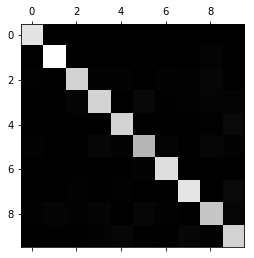

In [19]:
# 使用图像来表示混淆矩阵
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

因为所有的图像都在主对角线上，所有该混淆矩阵看上去不错，5 号分类器看上去颜色深一点，说明它的预测效果没有其他分类器好

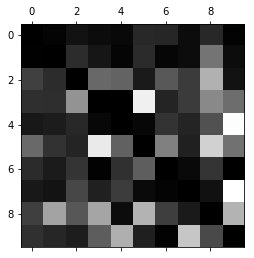

In [20]:
# 查看错误率，row_sums 是每个分类中实际的样本数
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums 
np.fill_diagonal(norm_conf_mx, 0) # 填充对角线，只留出错误的数据
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


8 和 9 两列比较白，意味着很多数字都错误的分类到了 8 和 9 两个数上；颜色非常深的行，意味着这个数字基本上预测对了，例如 1；

对于你想调优的分类器，你可以相应的增加样本；或优化样本图片（使用 Scikit-Image, Pillow, or OpenCV），使他们都处于图片正中间，且不要过于偏斜。

## 多个 label 的分类器

向分类器输入一组数据，它会输出多个预测值，例如下面的程序，可以同时预测图片是否是大数（>=7）及图片是否是奇数

In [21]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# Kneighbors 分类器可以同时输出多组预测值
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# 你可以使用 f1_score + 交叉验证 的方法来衡量多值分类器的效果
# 如果大数的图片远远多于奇数的图片，你可以将对每个label赋予一个权重，权重值根据其值的占比来设定
#  方法也很简单，将下面的参数 average 设为 average="weighted" 即可
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

## 多输出的分类器

将多 label 的分类器进行扩展，每个 label 不止是 2 个值的分类器为多输出的分类器，下面的例子是：

特征为带有噪音的图片（每个像素在原有图片的基础上加入噪声），target 为无噪音的图片，预测输出一张没有噪音的图片，即图片的每个像素为 1 个 label，每个 label 的取值范围为 0-255